# Red Neuronal Cuántica

In [1]:
import pandas as pd
import seaborn as sea
from matplotlib import pyplot as plt
from IPython.display import clear_output


from sklearn.datasets import load_iris, load_wine
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

import qiskit
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit.library import *
from qiskit_algorithms.optimizers import *
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC, NeuralNetworkClassifier
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.neural_networks import SamplerQNN

import warnings

warnings.filterwarnings('ignore')
sea.set_palette("Set1")

## Dataset de prueba

Para demostrar simplemente el funcionamiento de un clasificador cuántico se usará un dataset de educación muy popular: **Iris** de sklearn

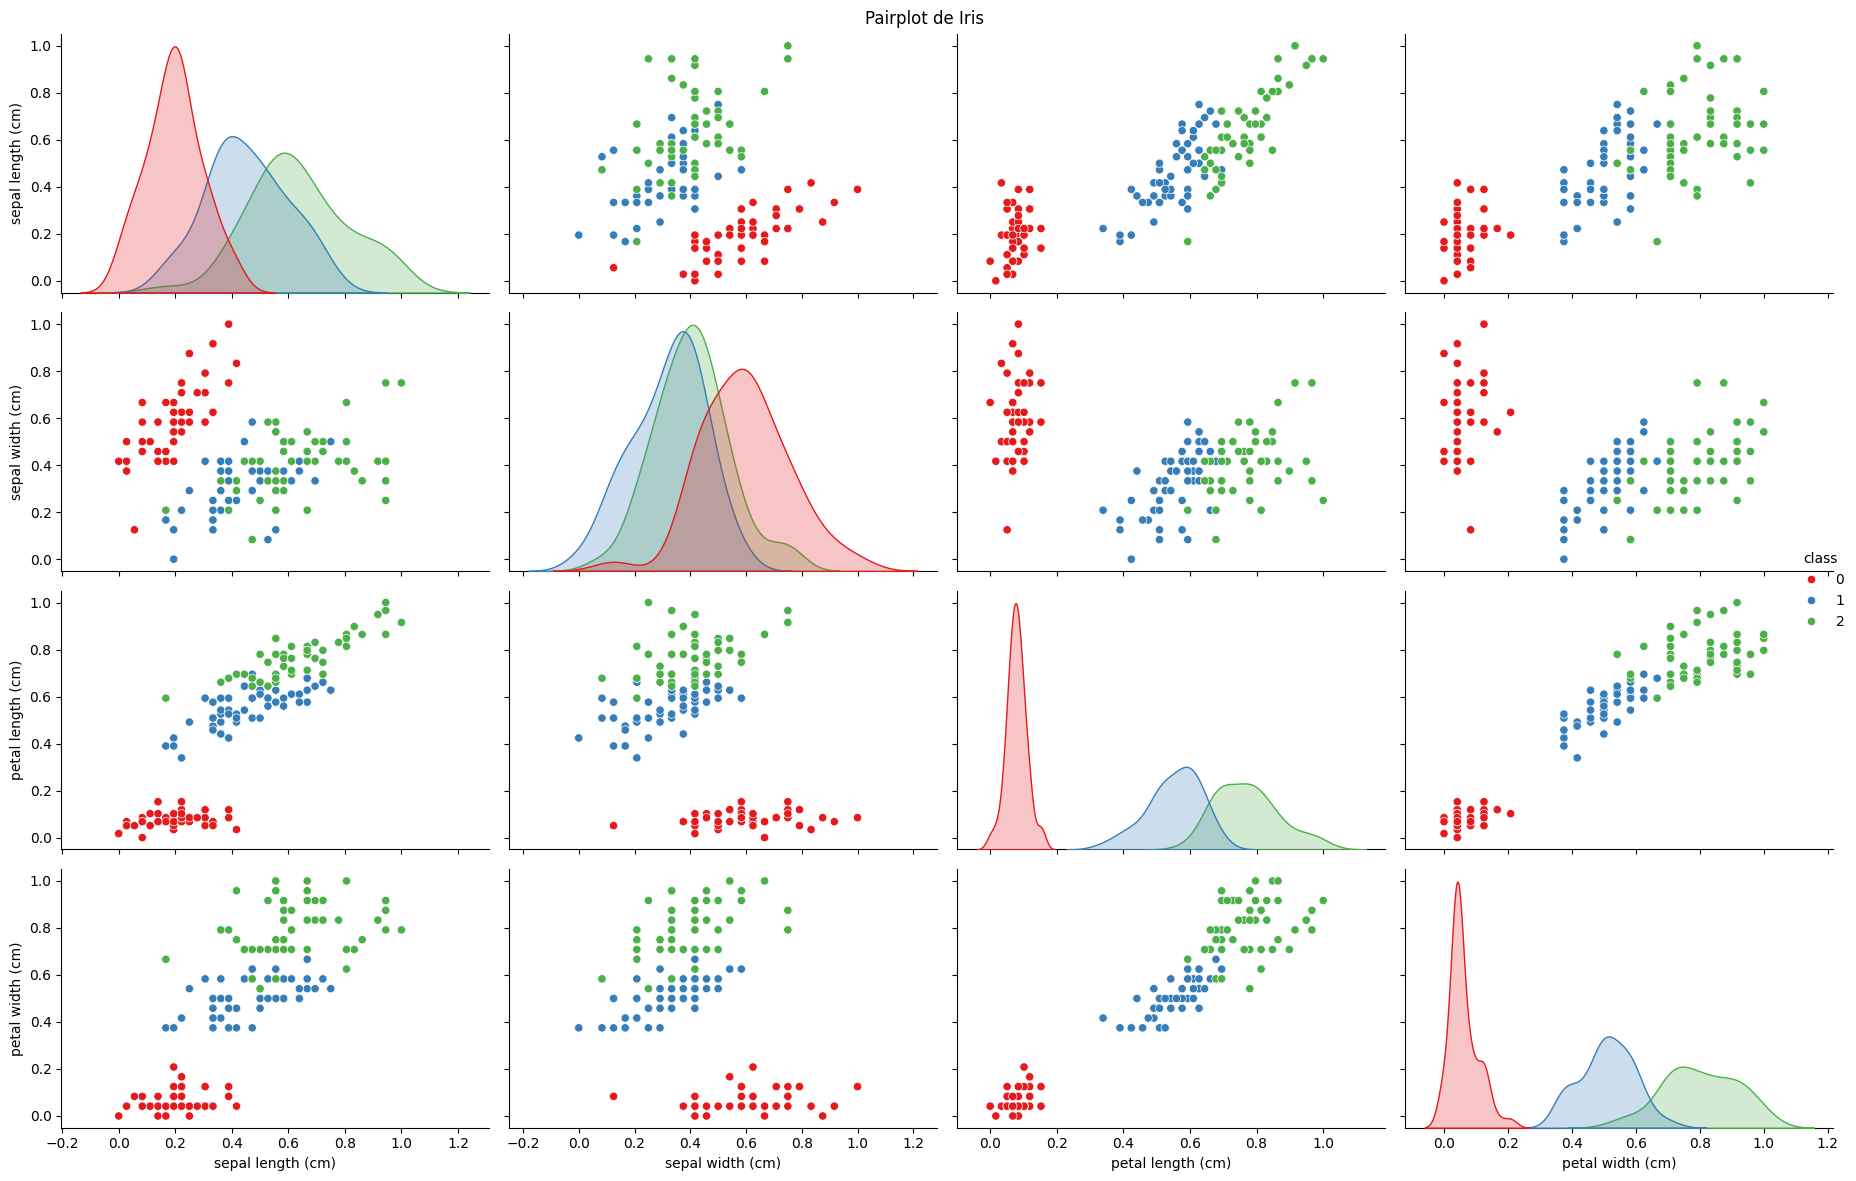

In [112]:
iris = load_iris()
features = iris.data
features = MinMaxScaler().fit_transform(features)
labels = iris.target

algorithm_globals.random_seed = 5338
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

df = pd.DataFrame(features, columns=iris.feature_names)
df["class"] = pd.Series(iris.target)

sea.pairplot(df, hue="class", palette="Set1", height=3, aspect=1.5);
plt.suptitle('Pairplot de Iris')
plt.tight_layout()
plt.show()

## Clasificador clásico

Para comparar resultados, se entrenan un support vector classifier  y un Multi-Layer Perceptron

### SVC

In [3]:
svc = SVC(verbose=0,)
svc.fit(X_train, y_train)
train_score_SVC = svc.score(X_train, y_train)
test_score_SVC = svc.score(X_test, y_test)

print(f"SVC con el data de entrenamiento: {train_score_SVC:.2f}")
print(f"SVC con el data de prueba:        {test_score_SVC:.2f}")

SVC con el data de entrenamiento: 0.98
SVC con el data de prueba:        0.97


### MLP

In [4]:
mpl = MLPClassifier(verbose=0)
mpl.fit(X_train, y_train)
train_score_MPL = mpl.score(X_train, y_train)
test_score_MPL = mpl.score(X_test, y_test)

print(f"MPL con el data de entrenamiento: {train_score_MPL:.2f}")
print(f"MPL con el data de prueba:        {test_score_MPL:.2f}")

MPL con el data de entrenamiento: 0.94
MPL con el data de prueba:        0.97


## Clasificador cuántico

### Variational Quantum Classifier 

El clasificador cuántico variacional es el más simple de los clasificadores cuánticos.

Se tiene primero que mapear las variables y parametrizar el circuito

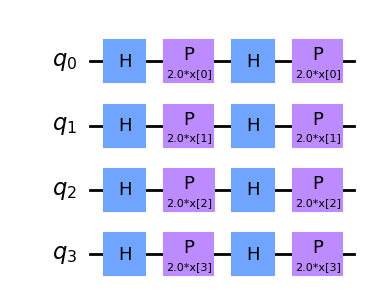

In [5]:
num_features = features.shape[1]

feature_map = ZFeatureMap(feature_dimension=num_features, reps=2)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

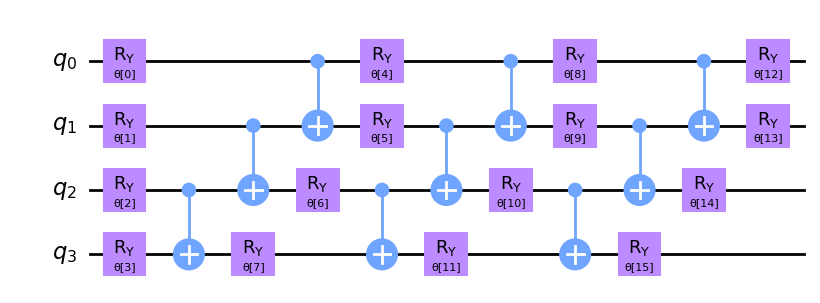

In [6]:
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

Finalmente se construye el backend del circuito

In [21]:
optimizer = COBYLA(maxiter=100)
sampler = Sampler()

objective_func_vals = []
plt.rcParams["figure.figsize"] = (10, 5)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Valor de la función objetivo")
    plt.xlabel("Iteración")
    plt.ylabel("Valor")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

### Entrenamiento

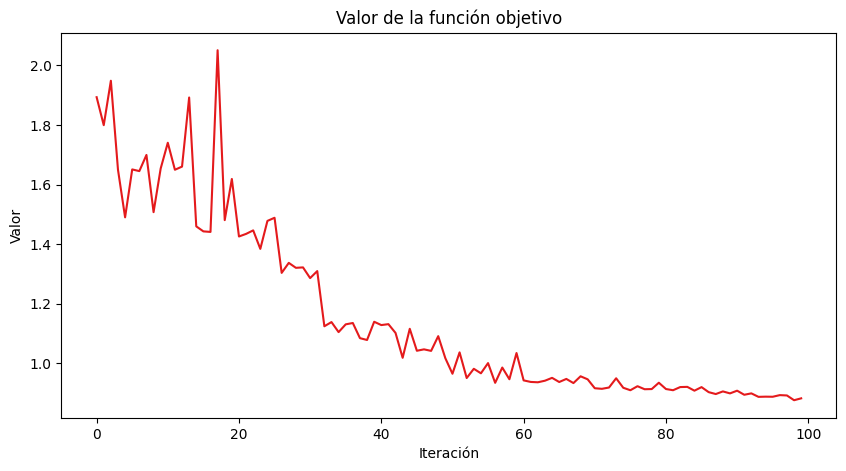

VQC con el data de entrenamiento: 0.91
VQC con el data de prueba:        0.97


In [8]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []
vqc.fit(X_train, y_train)

train_score_VQC = vqc.score(X_train, y_train)
test_score_VQC = vqc.score(X_test, y_test)

print(f"VQC con el data de entrenamiento: {train_score_VQC:.2f}")
print(f"VQC con el data de prueba:        {test_score_VQC:.2f}")

### Quantum Neural Network Classifier

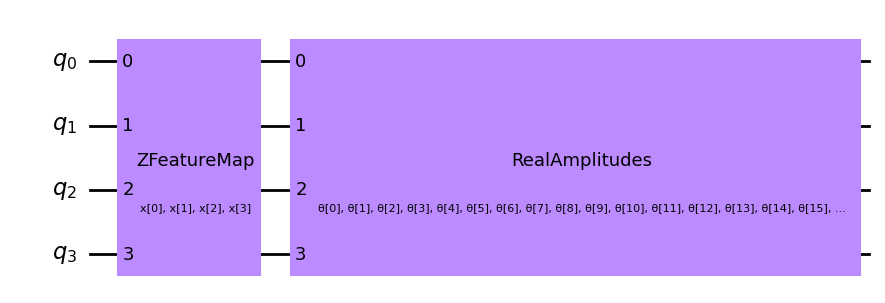

In [45]:
qc = QNNCircuit(feature_map=ZFeatureMap(feature_dimension=num_features, reps=2), ansatz=RealAmplitudes(num_features, reps=5))
qc.draw("mpl", style="clifford")

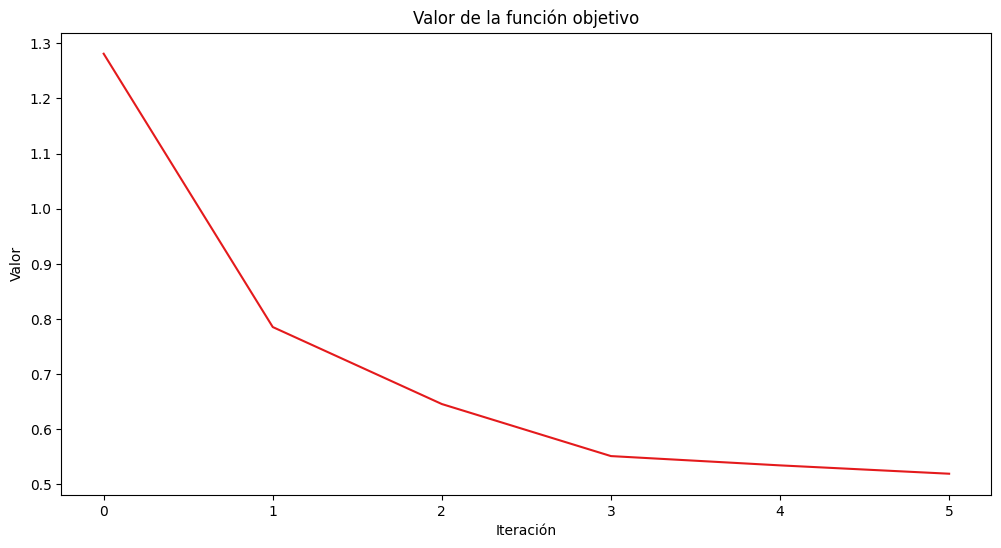

QNN con el data de entrenamiento: 0.66
QNN con el data de prueba:        0.70


In [46]:
def parity(x):
    return "{:b}".format(x).count("1") % 2

classes = 3

sampler_qnn = SamplerQNN(
    circuit=qc,
    interpret=parity,
    output_shape=classes,
)

qnn = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=L_BFGS_B(maxiter=5), callback=callback_graph
)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
qnn.fit(X_train, y_train)

train_score_qnn = qnn.score(X_train, y_train)
test_score_qnn = qnn.score(X_test, y_test)

print(f"QNN con el data de entrenamiento: {train_score_qnn:.2f}")
print(f"QNN con el data de prueba:        {test_score_qnn:.2f}")

## Comparación

In [47]:
print('| Model | Train Score | Test Score |')
print('| SVC   | {:.3f}       | {:.3f}      |'.format(train_score_SVC, test_score_SVC))
print('| MPL   | {:.3f}       | {:.3f}      |'.format(train_score_MPL, test_score_MPL))
print('| VQC   | {:.3f}       | {:.3f}      |'.format(train_score_VQC, test_score_VQC))
print('| QNN   | {:.3f}       | {:.3f}      |'.format(train_score_qnn, test_score_qnn))

| Model | Train Score | Test Score |
| SVC   | 0.983       | 0.967      |
| MPL   | 0.942       | 0.967      |
| VQC   | 0.908       | 0.967      |
| QNN   | 0.658       | 0.700      |


En este pequeño ejercicio con el 'toy' dataset de Iris, podemos ver como los métodos clásicos de ML y NN superan todavia a los modelos cuánticos. Esto era de esperarse por los años de ventaja que se lleva optimizando dichos modelos y por la complejidad que ellos poseen, mientras que los modelos cuánticos son todavia un área de investigacion actual. Sin tomar en cuenta *Iris* es un dataset pequeño, poco complejo, y de naturaleza no-cuántica. A pesar de todo, los clasificadores cuánticos demuestran resultados robustos tanto en informacion de entrenamiento como en información previamente no vista. Son scores no despreciables y representan un buen modelo y otro aceptable (esto se debe a que VQC es un QNN que usa circuitos variacionales). 
Las ventajas de las redes neuronales las encontramos en datasets más grandes y complejos, dónde la naturaleza cuántica de los qubits nos ayuda a encontras patrones más complejos. Y si la información lo permite, podemos construir códigos más eficientes computacionalmente.

# Wine Dataset

De igual manera vamos a comparar resultados pero con el dataset *wine dataset* de sklearn. 

In [113]:
wine = load_wine()
features = wine.data
features = MinMaxScaler().fit_transform(features)
y = wine.target
target = 'wine class'

df = pd.DataFrame(features, columns=wine.feature_names)
X = df.copy()
df[target] = pd.Series(wine.target)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  wine 

### Análisis y preparación de datos

El análisis y preparación se hará de forma rápida pues no es el propósito de este proyecto.

Debido a la capacidad que poseemos de computadoras cuánticas (que no es mucha) debemos de reducir el numero de variables para poder reducir el numero de qubits del sistema.

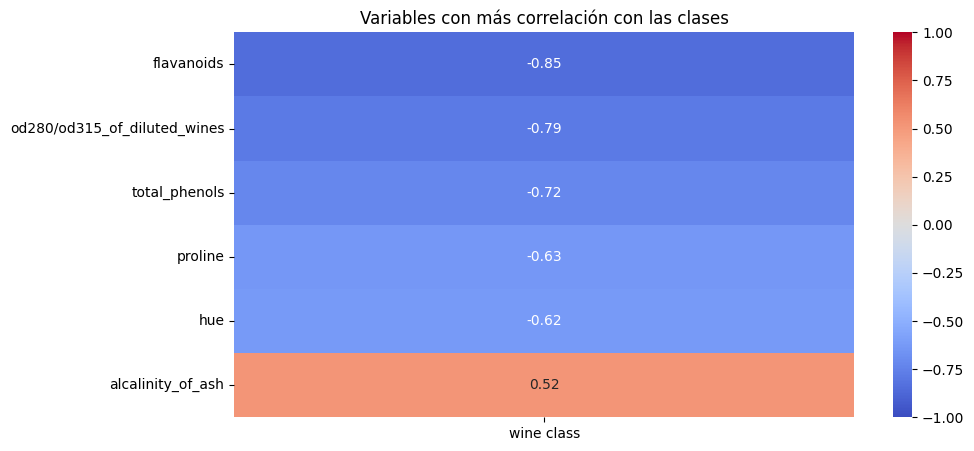

In [117]:
correlation_matrix = df.corr().abs()[[target]]
top_features = correlation_matrix.sort_values(by=target, ascending=False).head(7).index[1:].to_list()
top_features.append(target)
X = df[top_features]
corr = X.corr()
sea.heatmap(corr[[target]][:-1], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Variables con más correlación con las clases')
plt.show()

### Circuito cuántico

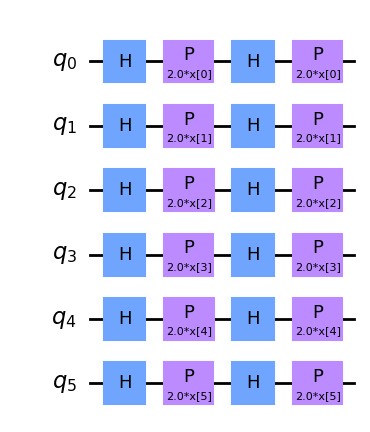

In [103]:
X_train, X_test, y_train, y_test = train_test_split(
    X.drop(target, axis=1), y, train_size=0.8, random_state=algorithm_globals.random_seed
)
num_features = X.shape[1]-1

feature_map = ZFeatureMap(feature_dimension=num_features, reps=2)
feature_map.decompose().draw(output="mpl", style="clifford", fold=30)

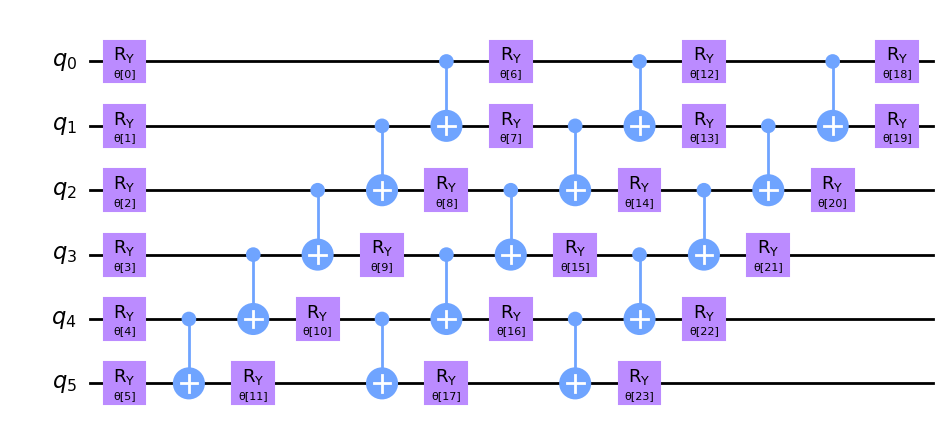

In [104]:
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

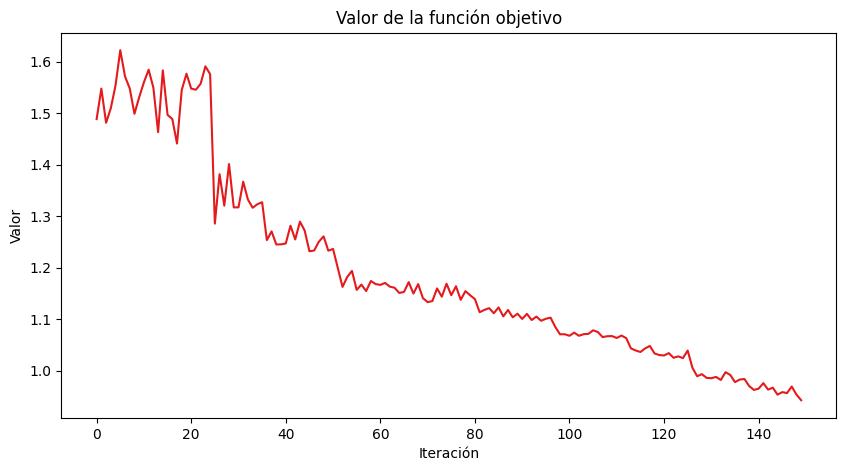

VQC con el data de entrenamiento: 0.95
VQC con el data de prueba:        0.89


In [106]:
optimizer = COBYLA(maxiter=150)
sampler = Sampler()

vqc = VQC(ansatz=ansatz, feature_map=feature_map, sampler=sampler, optimizer=optimizer, callback=callback_graph)

objective_func_vals = []
vqc.fit(X_train, y_train)

train_score_VQC = vqc.score(X_train, y_train)
test_score_VQC = vqc.score(X_test, y_test)

print(f"VQC con el data de entrenamiento: {train_score_VQC:.2f}")
print(f"VQC con el data de prueba:        {test_score_VQC:.2f}")

# Conclusiónes

Los clasificadores cuánticos tienen el potencial de superar a los clasificadores clásicos en ciertas tareas debido a su capacidad para procesar y analizar información de manera paralela y probabilística, gracias a los principios de superposición y entrelazamiento cuántico. Esto podría permitir un rendimiento más rápido y eficiente en la clasificación de datos complejos y grandes conjuntos de datos.

Sin embargo, la implementación de algoritmos de clasificación cuántica enfrenta desafíos significativos. Requiere tecnologías cuánticas emergentes, como qubits estables y operaciones cuánticas precisas, así como también la corrección de errores cuánticos para mantener la precisión de los cálculos. Además, la programación y el diseño de algoritmos cuánticos son considerablemente diferentes de los enfoques clásicos, lo que requiere un nuevo conjunto de habilidades y conocimientos.

A pesar de todo, en este reporte se ha logrado demostrar la eficacia y alcance de estos algoritmos a pesar de su aun no tan desarrollada tecnología.

# Referencias

> Scikit-learn. (2022). Wine recognition dataset. https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html

> Scikit-learn. (2022). Iris plants dataset. https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html